In [ ]:
!gdown 1-ETDJHUh9kIiSkXvhw-IKePVnISTLZG1

Downloading...
From (original): https://drive.google.com/uc?id=1-ETDJHUh9kIiSkXvhw-IKePVnISTLZG1
From (redirected): https://drive.google.com/uc?id=1-ETDJHUh9kIiSkXvhw-IKePVnISTLZG1&confirm=t&uuid=61f5cda8-417c-4b38-98bb-5ecb8312a55b
To: /content/height_maps_pos.zip
100% 1.07G/1.07G [00:11<00:00, 91.9MB/s]


In [ ]:
!gdown 1ESYHuSkQzq9_eY8XeHAxnSlzwHfi9s29

Downloading...
From (original): https://drive.google.com/uc?id=1ESYHuSkQzq9_eY8XeHAxnSlzwHfi9s29
From (redirected): https://drive.google.com/uc?id=1ESYHuSkQzq9_eY8XeHAxnSlzwHfi9s29&confirm=t&uuid=906241f6-8e59-4219-be9b-a768ee242e14
To: /content/height_mapt_pos.zip
100% 637M/637M [00:15<00:00, 42.2MB/s]


In [ ]:
!gdown 1-RDojjxVRA1U5jHKwymihfigcpILc08k

Downloading...
From (original): https://drive.google.com/uc?id=1-RDojjxVRA1U5jHKwymihfigcpILc08k
From (redirected): https://drive.google.com/uc?id=1-RDojjxVRA1U5jHKwymihfigcpILc08k&confirm=t&uuid=9be3aaa7-0ba6-42e5-b766-fd70c2275483
To: /content/images_full.zip
100% 450M/450M [00:07<00:00, 61.5MB/s]


In [ ]:
!gdown 1-Ia8DBdX24SpoCUEiHdNHA1aoslV-IXO

Downloading...
From (original): https://drive.google.com/uc?id=1-Ia8DBdX24SpoCUEiHdNHA1aoslV-IXO
From (redirected): https://drive.google.com/uc?id=1-Ia8DBdX24SpoCUEiHdNHA1aoslV-IXO&confirm=t&uuid=9ea4ab64-a260-4757-bc3e-352fcb42b953
To: /content/height_maps_neg.zip
100% 1.01G/1.01G [00:20<00:00, 48.2MB/s]


In [ ]:
!gdown 1bfoUwRZnk6bQSNVcFDTk79-93pCmVa9J

Downloading...
From (original): https://drive.google.com/uc?id=1bfoUwRZnk6bQSNVcFDTk79-93pCmVa9J
From (redirected): https://drive.google.com/uc?id=1bfoUwRZnk6bQSNVcFDTk79-93pCmVa9J&confirm=t&uuid=5d439545-a3b6-4fc5-b6c0-9053521d98a6
To: /content/height_mapt_neg.zip
100% 629M/629M [00:07<00:00, 89.2MB/s]


In [ ]:
!unzip images_full.zip > /dev/null

In [ ]:
!unzip height_mapt_pos.zip > /dev/null

In [ ]:
import numpy as np
img = np.load("/content/height_map_tiff/heightmap_lat_-58_to_60_lon_178_to_180.npy")
height = img['height']

FileNotFoundError: [Errno 2] No such file or directory: '/content/height_map_tiff/heightmap_lat_-58_to_60_lon_178_to_180.npy'

In [ ]:
cd /content

/content


In [ ]:
!unzip /content/height_mapt_pos.zip > /dev/null

In [ ]:
!mv height_map_tiff/*.tif /content/height_map_tiff

In [ ]:
mkdir height_maps

In [ ]:
!mv height_maps_positive/*.png /content/height_maps

In [ ]:
!pip install rasterio > /dev/null

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import rasterio
import numpy as np

class LunarTerrainDataset(Dataset):
    def __init__(self, image_dir, heightmap_dir, transform=None):
        self.image_dir = image_dir
        self.heightmap_dir = heightmap_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.heightmap_filenames = sorted(os.listdir(heightmap_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load terrain image
        image_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(img_path).convert('RGB')

        # Load corresponding height map image
        heightmap_filename = self.heightmap_filenames[idx]
        heightmap_path = os.path.join(self.heightmap_dir, heightmap_filename)
        heightmap = Image.open(heightmap_path).convert('L')  # Load as grayscale

        # Resize and normalize height map
        heightmap = heightmap.resize((224, 224))
        heightmap = np.array(heightmap) / 255.0  # Normalize to [0, 1]

        if self.transform:
            image = self.transform(image)

        heightmap = torch.tensor(heightmap, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, heightmap

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 3. Initialize Dataset and DataLoader
image_dir = "/content/cropped_images"
heightmap_dir = "/content/height_maps"
dataset = LunarTerrainDataset(image_dir, heightmap_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # Reduced batch size

In [ ]:
class ResNetUNet(nn.Module):
    def __init__(self):
        super(ResNetUNet, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.base_layers = list(base_model.children())

        # Encoder layers (ResNet backbone)
        self.enc1 = nn.Sequential(*self.base_layers[:3])
        self.enc2 = nn.Sequential(*self.base_layers[3:5])
        self.enc3 = self.base_layers[5]
        self.enc4 = self.base_layers[6]
        self.enc5 = self.base_layers[7]

        # Decoder layers
        self.dec4 = self._decoder_block(2048, 1024)
        self.dec3 = self._decoder_block(1024, 512)
        self.dec2 = self._decoder_block(512, 256)
        self.dec1 = self._decoder_block(256, 64)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Final output layer

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        # Encoder forward pass
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)

        # Decoder forward pass with skip connections
        dec4 = self.dec4(enc5) + enc4
        dec3 = self.dec3(dec4) + enc3
        dec2 = self.dec2(dec3) + enc2
        dec1 = self.dec1(dec2) + enc1
        output = self.upsample(dec1)
        output = self.final(output)

        return output

# 5. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
        # Clear cache before each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Training
        model.train()
        train_loss = 0
        for images, heightmaps in dataloader:
            images = images.to(device, non_blocking=True)
            heightmaps = heightmaps.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, heightmaps)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(dataloader):.4f}")

torch.save(model.state_dict(), "resunet_model.pth")

Epoch [1/20], Loss: 0.0561
Epoch [2/20], Loss: 0.0427
Epoch [3/20], Loss: 0.0378
Epoch [4/20], Loss: 0.0321
Epoch [5/20], Loss: 0.0282
Epoch [6/20], Loss: 0.0243
Epoch [7/20], Loss: 0.0219
Epoch [8/20], Loss: 0.0193
Epoch [9/20], Loss: 0.0165
Epoch [10/20], Loss: 0.0143
Epoch [11/20], Loss: 0.0128
Epoch [12/20], Loss: 0.0118
Epoch [13/20], Loss: 0.0106
Epoch [14/20], Loss: 0.0093
Epoch [15/20], Loss: 0.0083
Epoch [16/20], Loss: 0.0075
Epoch [17/20], Loss: 0.0074
Epoch [18/20], Loss: 0.0069
Epoch [19/20], Loss: 0.0065
Epoch [20/20], Loss: 0.0060


In [ ]:
ls

cropped_images/        height_maps_neg.zip    height_map_tiff/     images_full.zip
height_maps/           height_maps_positive/  height_mapt_neg.zip  resunet_model.pth
height_maps_negative/  height_maps_pos.zip    height_mapt_pos.zip  sample_data/


<ipython-input-33-9ef535dc6a6c>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/resunet_model.pth", map_location=device))


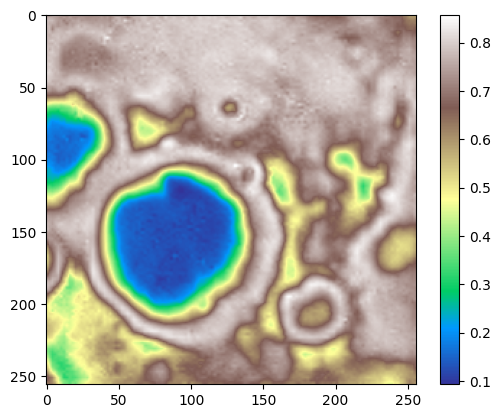

In [ ]:
import matplotlib.pyplot as plt
import cv2

def predict_height_map(model, image_path):
    model.eval()

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)  # Convert to tensor

    with torch.no_grad():
        predicted_hmap = model(img).cpu().numpy()[0, 0]  # Convert to numpy

    plt.imshow(predicted_hmap, cmap="terrain")
    plt.colorbar()
    plt.show()

    return predicted_hmap

# Load trained model & predict
model.load_state_dict(torch.load("/content/resunet_model.pth", map_location=device))
predicted_hmap = predict_height_map(model, "/content/cropped_images/lat_-0_to_2_lon_100_to_102.png")


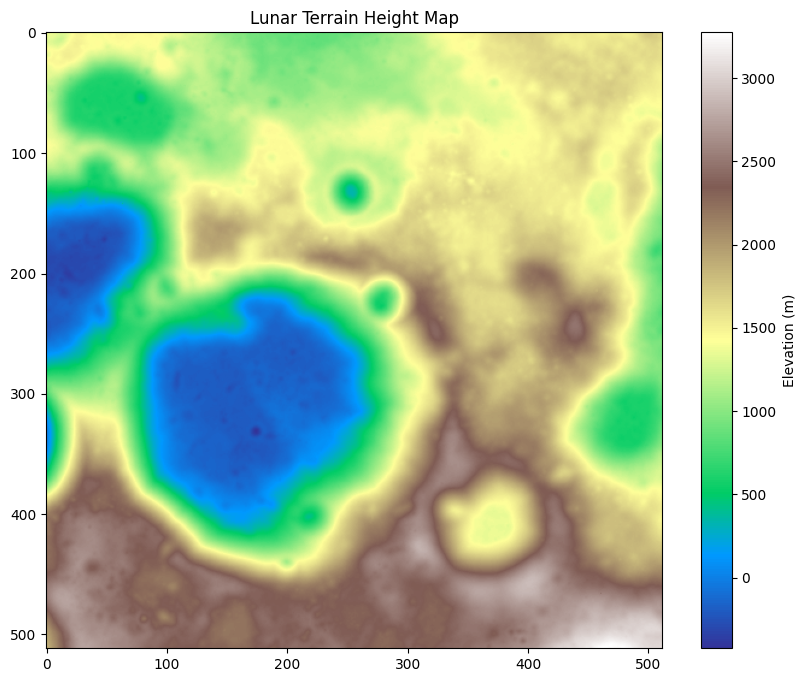

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the TIFF file
tiff_path = "height_map_tiff/heightmap_lat_-0_to_-2_lon_100_to_102.tif"

with rasterio.open(tiff_path) as src:
    height_map = src.read(1)  # Read band 1 (height values)
    height_map[height_map == src.nodata] = np.nan  # Handle NoData

# Plot the height map
plt.figure(figsize=(10, 8))
plt.imshow(height_map, cmap="terrain", origin="upper")
plt.colorbar(label="Elevation (m)")
plt.title("Lunar Terrain Height Map")
plt.show()


In [ ]:
def smooth_height_map(height_map, method="gaussian", sigma=2):
    """ Smooths the height map using Gaussian, median, or interpolation methods. """

    if method == "gaussian":
        return scipy.ndimage.gaussian_filter(height_map, sigma=sigma)  # Gaussian blur

    elif method == "median":
        return scipy.ndimage.median_filter(height_map, size=3)  # Median filter (size 3)

    elif method == "interpolation":
        from scipy.ndimage import zoom
        low_res = zoom(height_map, 0.5, order=3)  # Downsample
        return zoom(low_res, 2, order=3)  # Upsample (bicubic)

    return height_map  # Default (no smoothing)

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import scipy
def predict_and_visualize(model, image_path):
    model.eval()

    # Load and preprocess input image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0).to(device)  # Convert to tensor

    # Predict height map
    with torch.no_grad():
        predicted_hmap = model(img).cpu().numpy()[0, 0]  # Extract height map

    smooth_hmap = smooth_height_map(predicted_hmap, method='gaussian', sigma=2)

    # Apply height scaling
    scaled_hmap = smooth_hmap * 100

    fig = go.Figure(data=[go.Surface(z=scaled_hmap, colorscale="viridis")])
    fig.update_layout(title="Smoothed Lunar Terrain", autosize=True,
                      scene=dict(zaxis=dict(title="Height (Scaled)")))
    fig.show()

# Load trained model & predict
model.load_state_dict(torch.load("resunet_model.pth", map_location=device), strict=False)
predict_and_visualize(model, "/content/cropped_images/lat_-2_to_4_lon_100_to_102.png")


<ipython-input-50-5a2e5982c0c6>:31: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

cropped_images/        height_maps_neg.zip    height_map_tiff/     images_full.zip
height_maps/           height_maps_positive/  height_mapt_neg.zip  resnet_mode.pth
height_maps_negative/  height_maps_pos.zip    height_mapt_pos.zip  sample_data/


In [ ]:
!mv resunet_model.pth resnet_mode.pth

In [ ]:
!cp resnet_mode.pth /content/drive/MyDrive/